# Introducción a procesamiento de imágenes

Algunas librerías para procesar imágenes: numpy, pandas, cv2, skimage, PIL, matplotlib

- **Numpy** Para manipulación de matrices, utilizada para álgebra lineal, transformada de Fourier y capacidades de números aleatorios.
- **Pandas** Para manipulación y análisis de datos.
- **CV2** Para tareas de visión por computadora.
- **Skimage** Para aplicaciones de procesamiento de imágenes en Python.
- **Matplotlib** Para generar figuras y proporciona un conjunto de herramientas de interfaz gráfica de usuario.

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv 
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt



Image shape: (571, 800, 3)
Image shape: (571, 800, 3)


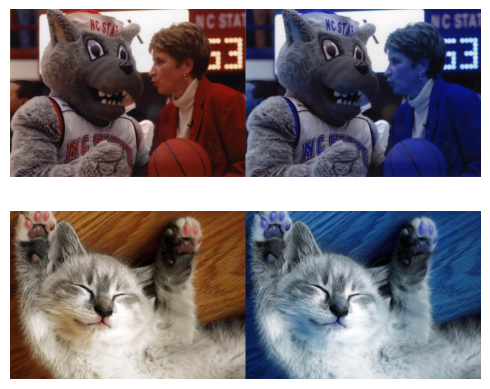

In [2]:
# Create a list to store the urls of the images
urls = ["https://iiif.lib.ncsu.edu/iiif/0016007/full/800,/0/default.jpg",
      "https://placekitten.com/800/571"]  
# Read and display the image
# loop over the image URLs, you could store several image urls in the list

fig, ax = plt.subplots(2,1)
for i,url in enumerate(urls):
  image = io.imread(url) 
  print(f'Image shape: {image.shape}')
  image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  final_frame = cv.hconcat((image, image_2))
  ax[i].imshow(final_frame)
  ax[i].axis('off')

### Ejercicio

Investigue acerca otras bases de colores distintas a RGB y BGR.

¿Que ventajas puede tener usas otras bases de colores para procesar imágenes?

## Ejemplo imágenes médicas

In [3]:
### Download the data, if not already on disk #################################
import os
if not os.path.exists('MRbrain.tar.gz'):
    # Download the data
    try:
        from urllib import urlopen
    except ImportError:
        from urllib.request import urlopen
    print("Downloading data, Please Wait (7.8MB)")
    opener = urlopen(
                'http://graphics.stanford.edu/data/voldata/MRbrain.tar.gz')
    open('MRbrain.tar.gz', 'wb').write(opener.read())

# Extract the data
import tarfile
tar_file = tarfile.open('MRbrain.tar.gz')
try:
    os.mkdir('mri_data')
except:
    pass
tar_file.extractall('mri_data')
tar_file.close()


### Read the data in a numpy 3D array #########################################
import numpy as np
data = np.array([np.fromfile(os.path.join('mri_data', 'MRbrain.%i' % i),
                                        dtype='>u2') for i in range(1, 110)])
data.shape = (109, 256, 256)
data = data.T
print(data.shape)
ratio = (0.5,0.5,1)

(256, 256, 109)


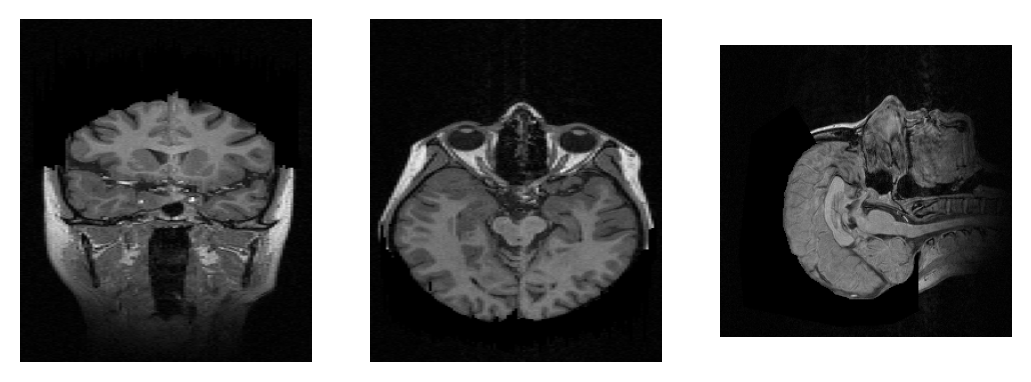

In [4]:

fig,ax =  plt.subplots(1,3)

ax[0].imshow(np.squeeze(data[128,:,:]),cmap='gray',aspect=ratio[0])
ax[1].imshow(np.squeeze(data[:,128,:]),cmap='gray',aspect=ratio[1])
ax[2].imshow(np.squeeze(data[:,:,56]),cmap='gray',aspect=ratio[2])
ax[0].axis('off');ax[1].axis('off');ax[2].axis('off');

plt.gcf().set_dpi(200)

(201, 216, 109)


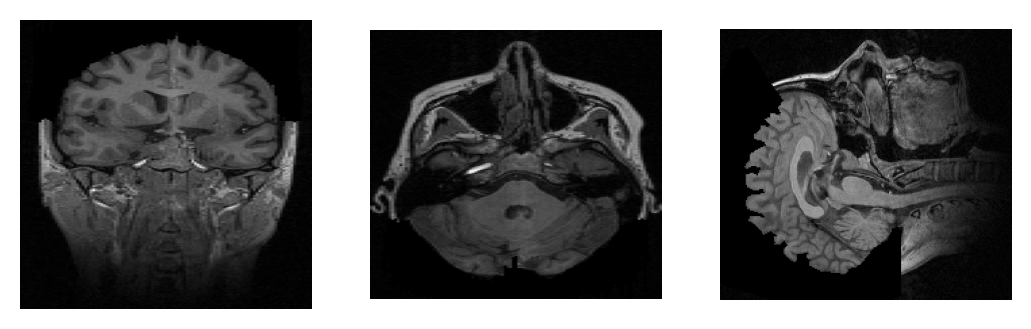

In [5]:
Crop_data = data[35:-20,40:,:]

S = Crop_data.shape
print(Crop_data.shape)

fig,ax =  plt.subplots(1,3)

ax[0].imshow(np.squeeze(Crop_data[S[0]//2,:,:]),cmap='gray',aspect=ratio[0])
ax[1].imshow(np.squeeze(Crop_data[:,S[1]//2,:]),cmap='gray',aspect=ratio[1])
ax[2].imshow(np.squeeze(Crop_data[:,:,S[2]//2]),cmap='gray',aspect=ratio[2])
ax[0].axis('off');ax[1].axis('off');ax[2].axis('off');

plt.gcf().set_dpi(200)

### Ejercicio

Genere un código para recortar la imagen y separar la cabeza del fondo

## Histograma de una imagen

In [6]:
def NormalizeAndCast(image,dtype='uint8'):
    if dtype == 'uint8':
        return (((image - image.min()) * (1/(image.max() - image.min()))) * 255).astype(dtype)
    elif dtype == 'float32' or dtype == 'float64':
        return (((image - image.min()) * (1/(image.max() - image.min() + np.finfo(image.dtype).eps)))).astype(dtype)
    else:
        raise TypeError("Only 'float32' , 'float32' and 'uint8' dtypes are allowed")

Max: 3678, Min: 1026, Mean: 1376.8458404541016
Max: 255, Min: 0, Mean: 33.29341125488281


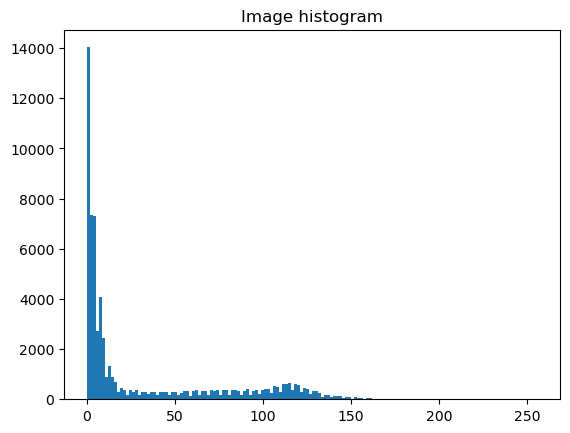

In [7]:
# Select slice
head_image = data[:,:,56]
print(f"Max: {head_image.max()}, Min: {head_image.min()}, Mean: {head_image.mean()}")
# Normalize image and cast to uint8
head_image =  NormalizeAndCast(head_image,dtype='uint8')
print(f"Max: {head_image.max()}, Min: {head_image.min()}, Mean: {head_image.mean()}")

plt.hist(head_image.ravel(),bins = 150, range = [0,256])
plt.title('Image histogram')
plt.show()

## Transformaciones y ecualización de histograma

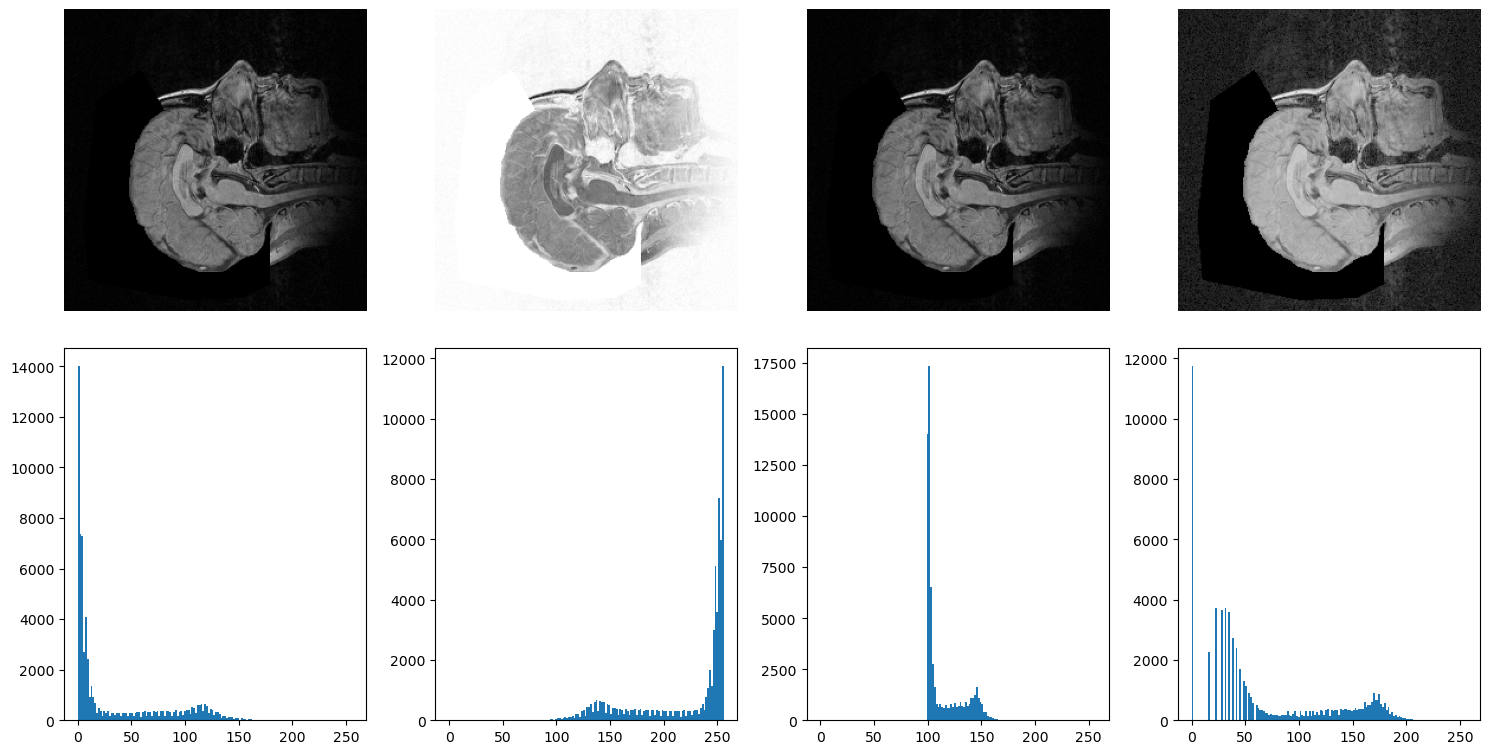

In [8]:
fig,ax = plt.subplots(2,4,figsize=(15,8))

im1 = 255 - head_image
im2 = (100.0/255)*head_image + 100
im3 = 255.0*(head_image/255.0)**(1/2)
ax.flat[0].imshow(head_image,cmap='gray');ax.flat[4].hist(head_image.ravel(),bins = 150, range = [0,256]);
ax.flat[1].imshow(im1,cmap='gray');ax.flat[5].hist(im1.ravel(),bins = 150, range = [0,256]);
ax.flat[2].imshow(im2,cmap='gray');ax.flat[6].hist(im2.ravel(),bins = 150, range = [0,256]);
ax.flat[3].imshow(im3,cmap='gray');ax.flat[7].hist(im3.ravel(),bins = 150, range = [0,256]);
ax.flat[0].axis('off');ax.flat[1].axis('off');ax.flat[2].axis('off');ax.flat[3].axis('off');

plt.gcf().set_dpi(100)
plt.tight_layout()

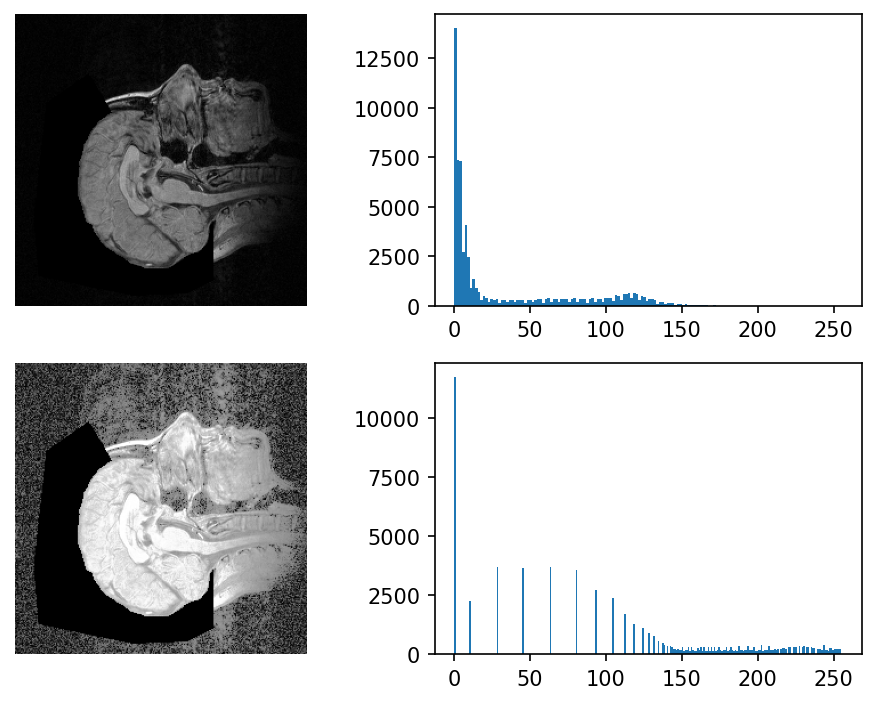

In [9]:
# function of histogram equalization
# This transform flattens the gray-level histogram so that all intensities are as equally common as possible

def histeq(image, num_bins=256):
    
    hist, bins = np.histogram(image.flatten(), num_bins, [0, 256])
    
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    
    equalized_image = np.interp(image.flatten(), bins[:-1], cdf_normalized)
    equalized_image = equalized_image.reshape(image.shape)
    
    return NormalizeAndCast(equalized_image,dtype='uint8')


# apply the function on your dark image to increase the contrast
# we could observe that the contrast of the black background has increased
num_bins = 256
im4 = histeq(head_image,num_bins = num_bins)

fig,ax = plt.subplots(2,2)
ax.flat[0].imshow(head_image,cmap='gray');ax.flat[1].hist(head_image.ravel(),bins = 150, range = [0,256]);
ax.flat[0].axis('off');
ax.flat[2].imshow(im4,cmap='gray');ax.flat[3].hist(im4.ravel(),bins = num_bins, range = [0,256]);
ax.flat[2].axis('off');

plt.gcf().set_dpi(150)
plt.tight_layout()

### Ejercicio

Experimente para distintos numeros de bins, en que afecta la cantidad de bins en ecualización?

## Convoluciones en 2D


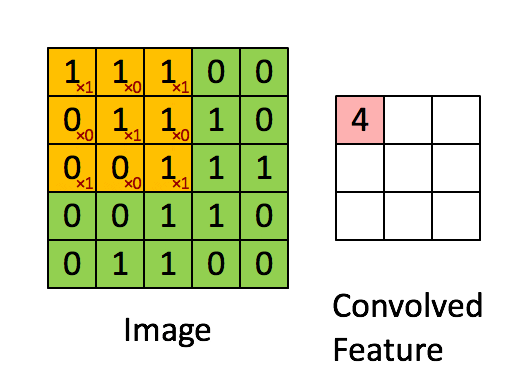

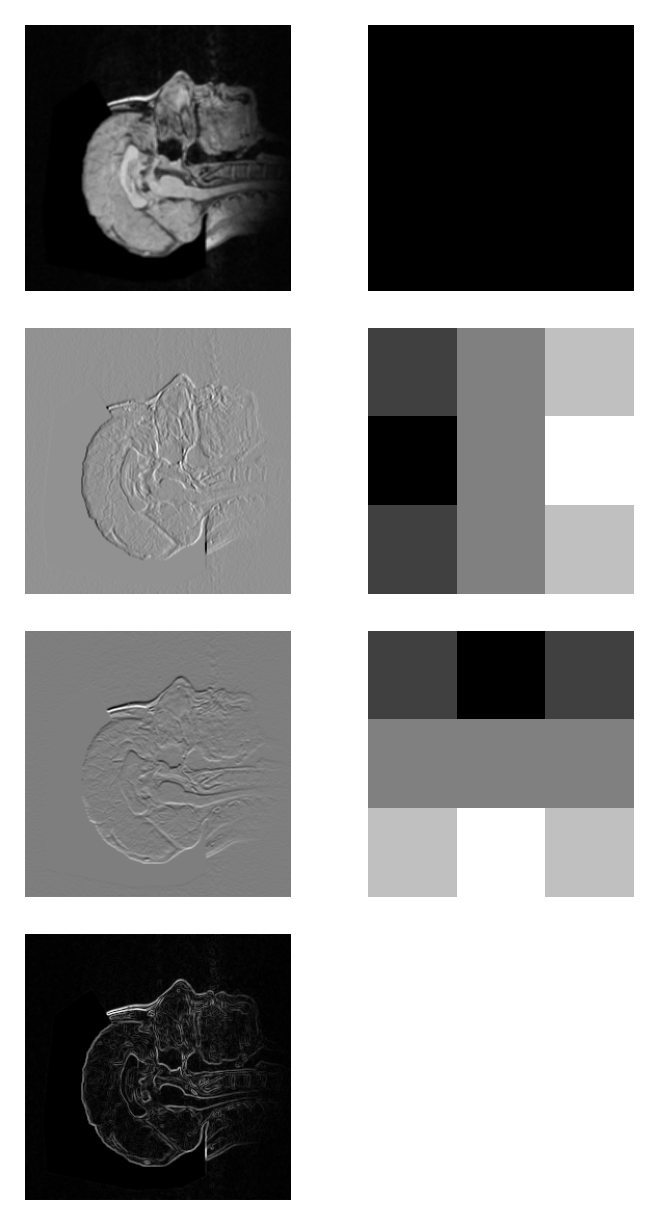

In [10]:
from scipy import signal

# Define filters
h1 = np.ones((3, 3)) / 9
h2 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
h3 = h2.T

# Convolve the image with the filter
y1 = signal.convolve2d(head_image, h1, mode='same', boundary='fill')
y2 = signal.convolve2d(head_image, h2, mode='same', boundary='fill')
y3 = signal.convolve2d(head_image, h3, mode='same', boundary='fill')
Gradient = np.sqrt(y2**2+y3**2)

# Plot the convolved image
fig,ax = plt.subplots(4,2,figsize=(3,5))

ax.flat[0].imshow(y1, cmap='gray');ax.flat[1].imshow(h1, cmap='gray');ax.flat[0].axis('off');ax.flat[1].axis('off')
ax.flat[2].imshow(y2, cmap='gray');ax.flat[3].imshow(h2, cmap='gray');ax.flat[2].axis('off');ax.flat[3].axis('off')
ax.flat[4].imshow(y3, cmap='gray');ax.flat[5].imshow(h3, cmap='gray');ax.flat[4].axis('off');ax.flat[5].axis('off')
ax.flat[6].imshow(Gradient, cmap='gray');ax.flat[6].axis('off');


fig.delaxes(ax.flat[7])
plt.gcf().set_dpi(250)
plt.tight_layout()

 [Deriving sobel gradient](https://nrsyed.com/2018/02/18/edge-detection-in-images-how-to-derive-the-sobel-operator/)

## Transformada de Fourier 2D

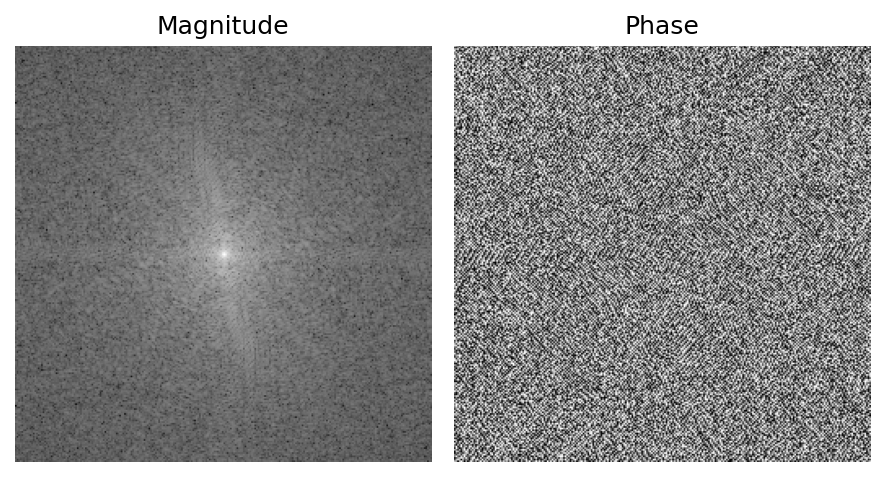

In [11]:
head_sim_k_space = np.fft.fftshift(np.fft.fft2(head_image.astype(float)))

# Plot the convolved image
fig,ax = plt.subplots(1,2,figsize=(6,10))

ax.flat[0].imshow(np.log(np.abs(head_sim_k_space)), cmap='gray');ax.flat[0].axis('off')
ax.flat[1].imshow(np.angle(head_sim_k_space), cmap='gray');ax.flat[1].axis('off')
ax.flat[0].set_title("Magnitude")
ax.flat[1].set_title("Phase")

plt.gcf().set_dpi(150)
plt.tight_layout()

### Filtros en frecuencia y fenómeno de Gibbs

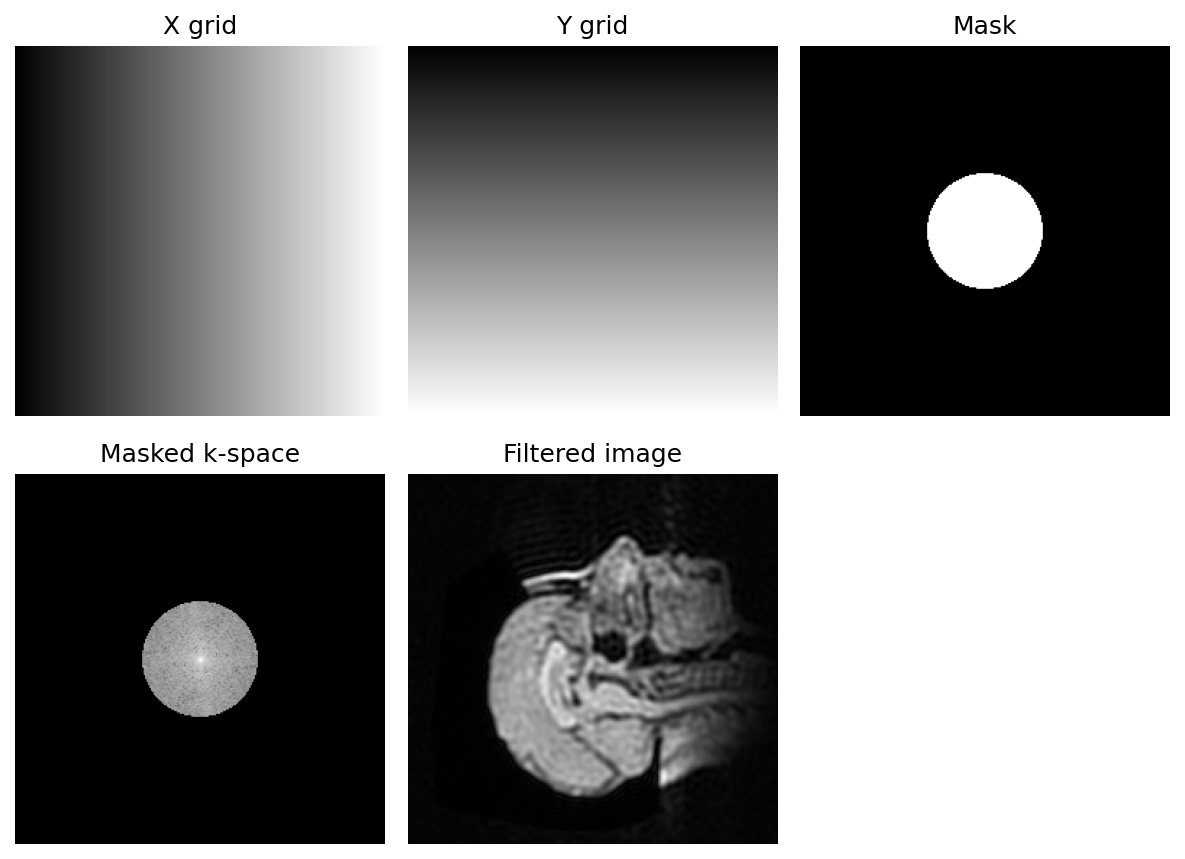

In [12]:
img_shape = head_sim_k_space.shape
x = np.arange(0,img_shape[0])
y = np.arange(0,img_shape[1])
X,Y = np.meshgrid(x,y)
X = X - np.mean(np.mean(x))
Y = Y - np.mean(np.mean(y))
r = 40
center = (0,0)
mask = np.where(((X - center[0])**2 + (Y-center[1])**2 <= r**2),1,0)

masked_kspace = head_sim_k_space * mask

head_image_filtered = np.fft.ifft2(np.fft.fftshift(masked_kspace))

# Plot the convolved image
fig,ax = plt.subplots(2,3,figsize=(8,6))

ax.flat[0].imshow(X, cmap='gray');ax.flat[0].axis('off')
ax.flat[1].imshow(Y, cmap='gray');ax.flat[1].axis('off')
ax.flat[2].imshow(mask, cmap='gray');ax.flat[2].axis('off')
ax.flat[3].imshow(np.log(np.abs(head_sim_k_space)) * mask, cmap='gray');ax.flat[3].axis('off')
ax.flat[4].imshow(np.abs(head_image_filtered), cmap='gray');ax.flat[4].axis('off')

ax.flat[4].set_title("Filtered image")
ax.flat[3].set_title("Masked k-space")
ax.flat[2].set_title("Mask")
ax.flat[0].set_title("X grid")
ax.flat[1].set_title("Y grid")

fig.delaxes(ax.flat[5])
plt.gcf().set_dpi(150)
plt.tight_layout()

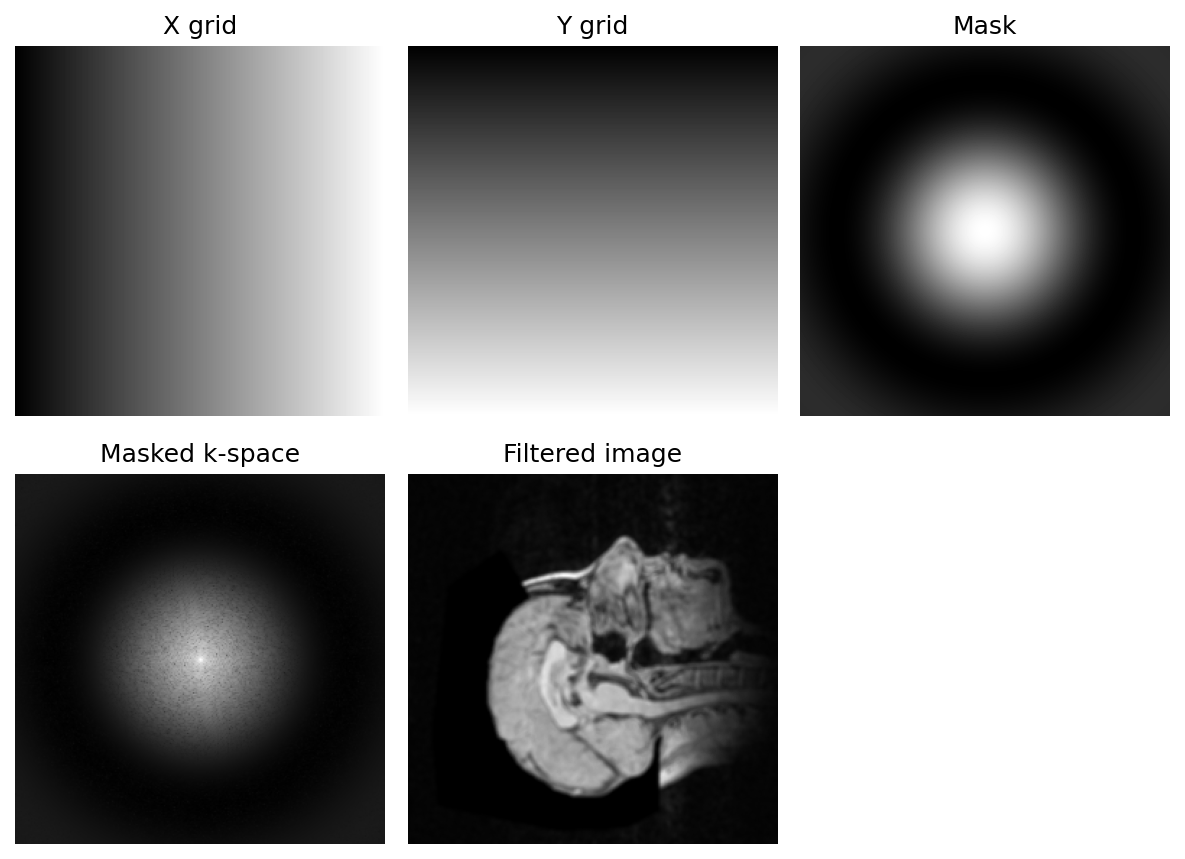

In [13]:
from scipy.special import j1

mu = 0
sigma = 35
mask = (1/(np.sqrt(2*np.pi)*sigma)) * np.exp((-1/(2*sigma**2)) * ((X - mu)**2 + (Y - mu)**2))
R = np.sqrt(X**2 + Y**2)
mask = j1(0.05*R) / (2*R)
masked_kspace = head_sim_k_space * mask

head_image_filtered = np.fft.ifft2(np.fft.fftshift(masked_kspace))

# Plot the convolved image
fig,ax = plt.subplots(2,3,figsize=(8,6))

ax.flat[0].imshow(X, cmap='gray');ax.flat[0].axis('off')
ax.flat[1].imshow(Y, cmap='gray');ax.flat[1].axis('off')
ax.flat[2].imshow(mask, cmap='gray');ax.flat[2].axis('off')
ax.flat[3].imshow(np.log(np.abs(head_sim_k_space)) * mask, cmap='gray');ax.flat[3].axis('off')
ax.flat[4].imshow(np.abs(head_image_filtered), cmap='gray');ax.flat[4].axis('off')

ax.flat[4].set_title("Filtered image")
ax.flat[3].set_title("Masked k-space")
ax.flat[2].set_title("Mask")
ax.flat[0].set_title("X grid")
ax.flat[1].set_title("Y grid")

fig.delaxes(ax.flat[5])
plt.gcf().set_dpi(150)
plt.tight_layout()

### Relación convolución 2D y respuesta al impulso

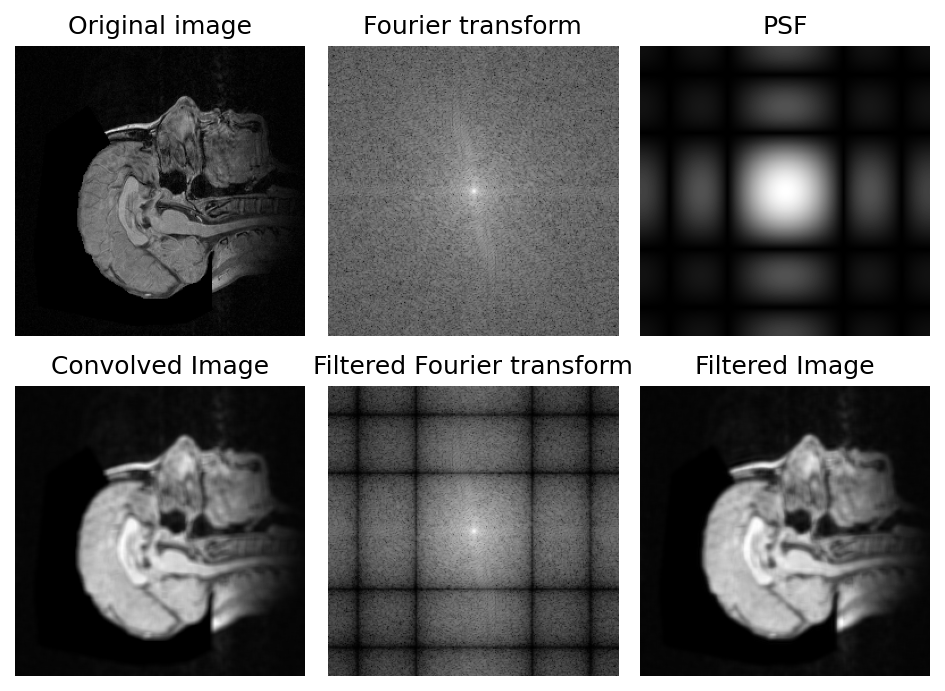

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, signal
from skimage import io, color, transform

# Plot the original image
plt.subplot(231)
plt.imshow(head_image, cmap='gray')
plt.title("Original image")
plt.axis('off')

# Compute the FFT of the image
ff = np.abs(np.fft.fft2(head_image.astype(float)))

# Plot the FFT
plt.subplot(232)
plt.imshow(np.fft.fftshift(np.log(ff + 1)), cmap='gray')
plt.title("Fourier transform")
plt.axis('off')

# Define the filter
h = np.ones((5, 5)) / 25

# Compute the frequency response of the filter
hf = np.abs(np.fft.fftshift(np.fft.fft2(h, s=head_image.shape)))

# Plot the filter's frequency response
plt.subplot(233)
plt.imshow(np.log(hf + 1), cmap='gray')
plt.title("PSF")
plt.axis('off')

# Convolve the image with the filter
y = signal.convolve2d(head_image.astype(float), h, mode='same', boundary='wrap')

# Plot the convolved image
plt.subplot(234)
plt.imshow(y, cmap='gray')
plt.title("Convolved Image")
plt.axis('off')

# Compute the FFT of the convolved image
yf = np.abs(fftpack.fft2(y))

# Plot the FFT of the convolved image
plt.subplot(235)
plt.imshow(np.fft.fftshift(np.log(yf + 1)), cmap='gray')
plt.title("Filtered Fourier transform")
plt.axis('off')

# Compute the FFT of the convolved image
yf = head_sim_k_space * hf
yf = np.fft.ifft2(np.fft.fftshift(yf))

# Plot the FFT of the convolved image
plt.subplot(236)
plt.imshow(np.abs(yf), cmap='gray')
plt.title("Filtered Image")
plt.axis('off')

plt.tight_layout()
plt.gcf().set_dpi(150)
plt.show()


#### Ejercicio

Realice el mismo procedimiento pero con el filtro

$$ \begin{bmatrix}
0 & -1 & 0 \\
-1 & 4 & -1 \\
0 & -1 & 0 
\end{bmatrix}  $$

Se cumple el mismo principio que con el filtro anterior?

### Submuestreo 

Aleatoric polynomial sampling 50.00%
Aleatoric polynomial sampling 10.00%


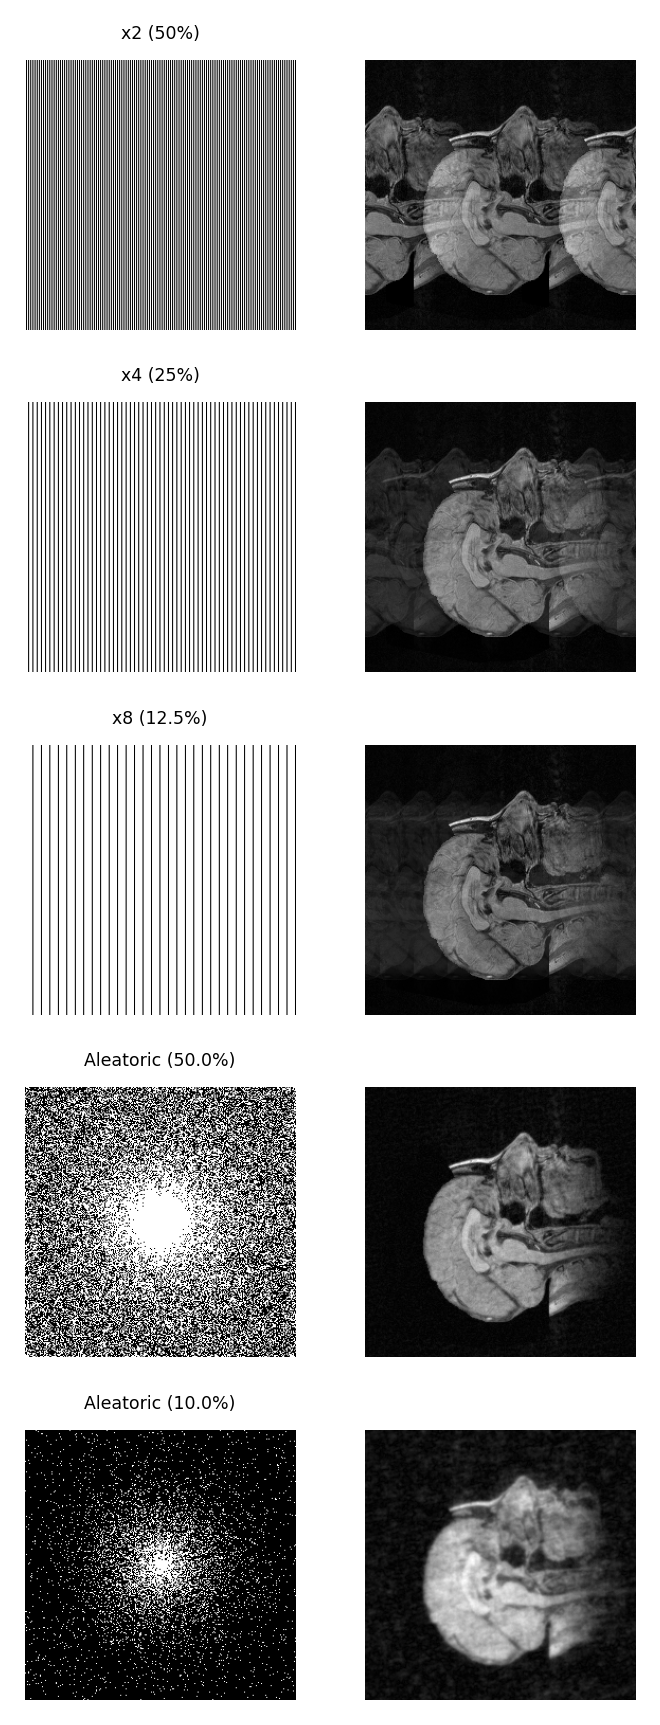

In [15]:
from scipy.io import loadmat

x = np.arange(1,head_image.shape[0]+1)
y = np.arange(1,head_image.shape[1]+1)
X,Y = np.meshgrid(x,y)
Sx2 = np.where( np.round(X) %  2 == 0,0,1)
Sx4 = np.where( np.round(X) %  4 == 0,0,1)
Sx8 = np.where( np.round(X) %  8 == 0,0,1)

SA = loadmat("DownSamplePatterns/S10-05.mat")
SA1 = SA["S50"]
SA2 = SA["S10"]

P1 = (np.sum(SA1)/SA1.size)*100
P2 = (np.sum(SA2)/SA2.size)*100
print(f"Aleatoric polynomial sampling {P1:.2f}%")
print(f"Aleatoric polynomial sampling {P2:.2f}%")

Ix2 = np.fft.ifft2(np.fft.fftshift(head_sim_k_space * Sx2))
Ix4 = np.fft.ifft2(np.fft.fftshift(head_sim_k_space * Sx4))
Ix8 = np.fft.ifft2(np.fft.fftshift(head_sim_k_space * Sx8))
IA1 = np.fft.ifft2(np.fft.fftshift(head_sim_k_space * SA1))
IA2 = np.fft.ifft2(np.fft.fftshift(head_sim_k_space * SA2))


# Plot the convolved image
fig,ax = plt.subplots(5,2,figsize=(3,7))

ax.flat[0].imshow(Sx2, cmap='gray');ax.flat[1].imshow(np.abs(Ix2), cmap='gray');ax.flat[0].axis('off');ax.flat[1].axis('off')
ax.flat[2].imshow(Sx4, cmap='gray');ax.flat[3].imshow(np.abs(Ix4), cmap='gray');ax.flat[2].axis('off');ax.flat[3].axis('off')
ax.flat[4].imshow(Sx8, cmap='gray');ax.flat[5].imshow(np.abs(Ix8), cmap='gray');ax.flat[4].axis('off');ax.flat[5].axis('off')
ax.flat[6].imshow(SA1, cmap='gray');ax.flat[7].imshow(np.abs(IA1), cmap='gray');ax.flat[6].axis('off');ax.flat[7].axis('off')
ax.flat[8].imshow(SA2, cmap='gray');ax.flat[9].imshow(np.abs(IA2), cmap='gray');ax.flat[8].axis('off');ax.flat[9].axis('off')

ax.flat[0].set_title("x2 (50%)",fontsize=5)
ax.flat[2].set_title("x4 (25%)",fontsize=5)
ax.flat[4].set_title("x8 (12.5%)",fontsize=5)
ax.flat[6].set_title(f"Aleatoric ({P1:.1f}%)",fontsize=5)
ax.flat[8].set_title(f"Aleatoric ({P2:.1f}%)",fontsize=5)

plt.gcf().set_dpi(250)
plt.tight_layout()